Retrieving USGS data for 01108000 from 2023-10-01 to 2023-10-30
Retrieving NOAA data for GHCND:USW00054777 from 2023-10-01 to 2023-10-30
Requesting NOAA data with parameters: {'datasetid': 'GHCND', 'datatypeid': 'TMAX,TMIN', 'stationid': 'GHCND:USW00054777', 'startdate': '2023-10-01', 'enddate': '2023-10-30', 'limit': 1000}
{'metadata': {'resultset': {'offset': 1, 'count': 60, 'limit': 1000}}, 'results': [{'date': '2023-10-01T00:00:00', 'datatype': 'TMAX', 'station': 'GHCND:USW00054777', 'attributes': ',,W,', 'value': 211}, {'date': '2023-10-01T00:00:00', 'datatype': 'TMIN', 'station': 'GHCND:USW00054777', 'attributes': ',,W,', 'value': 100}, {'date': '2023-10-02T00:00:00', 'datatype': 'TMAX', 'station': 'GHCND:USW00054777', 'attributes': ',,W,', 'value': 228}, {'date': '2023-10-02T00:00:00', 'datatype': 'TMIN', 'station': 'GHCND:USW00054777', 'attributes': ',,W,', 'value': 67}, {'date': '2023-10-03T00:00:00', 'datatype': 'TMAX', 'station': 'GHCND:USW00054777', 'attributes': ',,W,', 'v

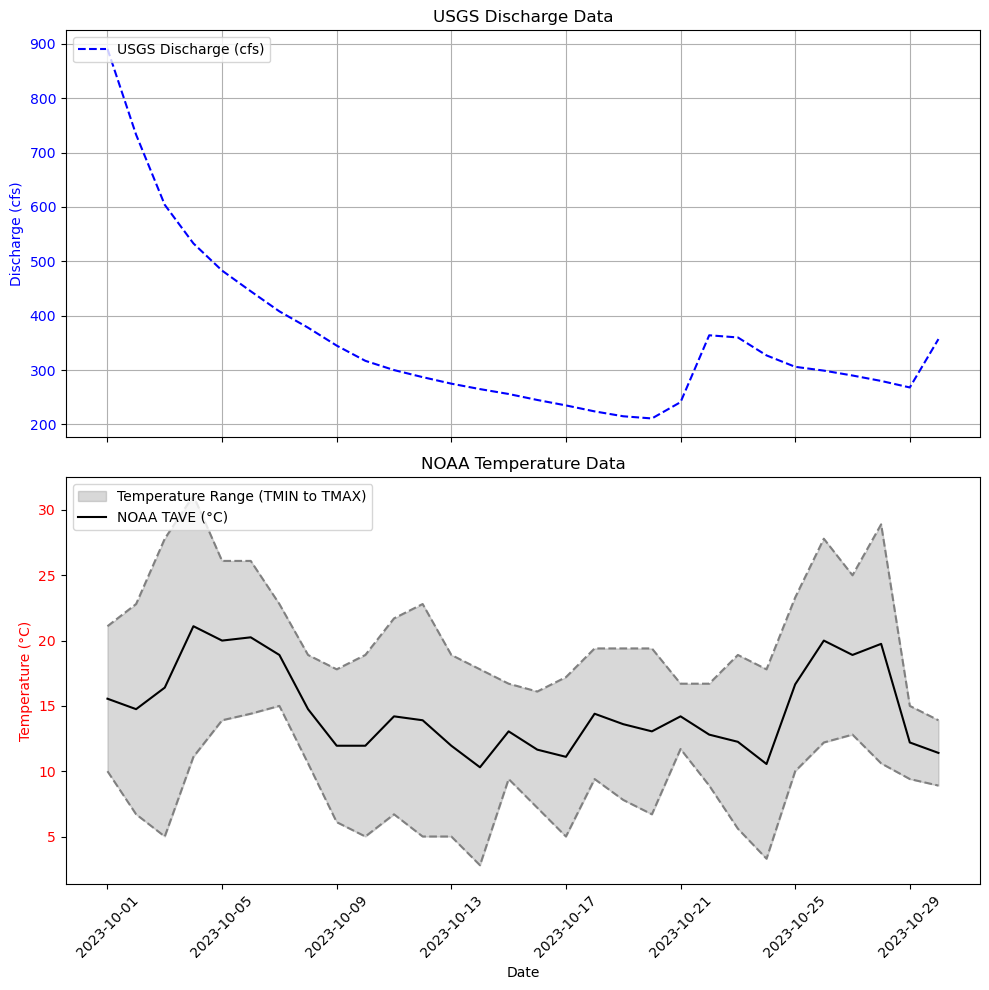

In [37]:
from dataretrieval import nwis  # For USGS data
import pandas as pd
import matplotlib.pyplot as plt
import requests


noaa_site_id= "GHCND:USW00054777"
usgs_site_id="01108000"
start_date = "2023-10-01"
end_date = "2023-10-30"
NOAA_API_TOKEN="lqbBOsoeMwxZbPbaOsZpjdSODFPAqQGG"


def grab_usgs_data(site_no, start_date, end_date):
    """
    Retrieve flow data from USGS.
    :param site_no: USGS site number
    :param start_date: Start date
    :param end_date: End date
    :return: USGS DataFrame
    """
    print(f"Retrieving USGS data for {site_no} from {start_date} to {end_date}")
    df = nwis.get_dv(
        sites=site_no,
        parameterCd="00060",
        statCd="00003",
        start=start_date,
        end=end_date,
    )[0].reset_index()

    df = df.rename(columns={'datetime': 'Date'})
    df['Date'] = df['Date'].dt.tz_convert(None)
    return df

def grab_noaa_data(site_id, start_date, end_date):
    """
    Retrieve climate data from NOAA.
    :param site_id: NOAA site ID
    :param start_date: Start date
    :param end_date: End date
    :return: NOAA Data
    """
    print(f"Retrieving NOAA data for {site_id} from {start_date} to {end_date}")
    # Use the NOAA Climate Data API (example URL)
    NOAA_API_TOKEN="lqbBOsoeMwxZbPbaOsZpjdSODFPAqQGG"

    url = f"https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
    headers = {"token": NOAA_API_TOKEN}  # Replace with your NOAA API token
    params = {
        "datasetid": "GHCND",            # Global Historical Climatology Network - Daily
        "datatypeid": "TMAX,TMIN",       # Request both TMAX and TMIN
        "stationid": site_id,       # Specific station ID
        "startdate": start_date,
        "enddate": end_date,
        "limit": 1000                    # Max records per request
    }
    print(f"Requesting NOAA data with parameters: {params}")
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()
    else:
        print("Error:", response.status_code, response.text)

    print(data)
    df = pd.DataFrame(data['results'])
    if not df.empty:
        df = df[['date', 'datatype', 'value']]
        df = df.pivot(index='date', columns='datatype', values='value').reset_index()
        df.columns = ['Date', 'TMAX', 'TMIN']
        df['TMAX'] = df['TMAX'] / 10
        df['TMIN'] = df['TMIN'] / 10
        df['Date'] = pd.to_datetime(df['Date'])
        df['TAVE'] = (df['TMAX']+df['TMIN'])/2
    else:
        print('grab_noaa_data df is empty')

    return df

usgs_data = grab_usgs_data(usgs_site_id, start_date, end_date)
noaa_data = grab_noaa_data(noaa_site_id, start_date, end_date)

def merge_data(usgs_data,noaa_data):

    merged_df = pd.merge(usgs_data, noaa_data, on='Date', how='inner')
    print(merged_df.head())
    return(merged_df)

test = merge_data(usgs_data,noaa_data)

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def create_plot(data):
    # Create a figure with two subplots (2 rows, 1 column)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Plot USGS discharge data on the first subplot (ax1)
    ax1.plot(data['Date'], data['00060_Mean'], label='USGS Discharge (cfs)', color='blue', linestyle='--')
    ax1.set_ylabel('Discharge (cfs)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('USGS Discharge Data')
    ax1.grid()

    # Plot NOAA temperature data on the second subplot (ax2)
    ax2.plot(data['Date'], data['TMAX'], color='gray',linestyle='--', label='_nolegend_')
    ax2.plot(data['Date'], data['TMIN'], color='gray',linestyle='--', label='_nolegend_')

    # Fill the area between TMIN and TMAX
    ax2.fill_between(data['Date'], data['TMIN'], data['TMAX'], color='gray', alpha=0.3, label='Temperature Range (TMIN to TMAX)')

    # Plot TAVE on the same subplot
    ax2.plot(data['Date'], data['TAVE'], label='NOAA TAVE (°C)', color='black')

    ax2.set_ylabel('Temperature (°C)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_title('NOAA Temperature Data')

    # Add legends for both subplots
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')

    # Set the x-axis label
    ax2.set_xlabel('Date')

    # Rotate the x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()

    return





create_plot(test)